In [2]:
import pandas as pd
import numpy as np

In [3]:
import glob, os

fake_list = glob.glob("dataset/fake/*.txt")
true_list = glob.glob("dataset/true/*.txt")


In [4]:
df = pd.DataFrame(columns=['file_num','text','annotation'])

# adding all labeled news
i = 1
for file_list in [fake_list, true_list]:
    for file in file_list:
        fileName = os.path.basename(os.path.splitext(file)[0]) # splitext get name without extension on position 0 and basename just the filename

        with open(file, 'r', encoding="utf8") as file_open:
            data = file_open.read().replace('\n', '')

        if i == 1:
            label = "fake"
        else:
            label = "true"
            
        df = df.append({
         "file_num": fileName,
         "text":  data,
         "annotation": label
        }, ignore_index=True)
        
    i+=1

df.head()

,file_num,text,annotation
0,1,Kátia Abreu diz que vai colocar sua expulsão e...,fake
1,10,"Dr. Ray peita Bolsonaro, chama-o de conservad...",fake
2,100,Reinaldo Azevedo desmascarado pela Polícia Fed...,fake
3,1000,Relatório assustador do BNDES mostra dinheiro ...,fake
4,1001,"Radialista americano fala sobre o PT: ""Eles ve...",fake


In [5]:
df['annotation'].value_counts()

fake    3600
true    3600
Name: annotation, dtype: int64

# Creating a feature prior to data cleaning
> Hypothesis: Fake news will have more ! and ? characters or upper-case text

In [6]:
import re
pattern = "[A-Z]|\!|\?"

# calculate the rate of upper-case, ! and ? characters by the total amount of characters (hypothesis - higher rate on fake news)
df["rate_chars"] = df.apply(lambda value: len(re.findall(pattern, value.text))/len(value.text), axis=1)
df.head()

,file_num,text,annotation,rate_chars
0,1,Kátia Abreu diz que vai colocar sua expulsão e...,fake,0.042033
1,10,"Dr. Ray peita Bolsonaro, chama-o de conservad...",fake,0.021390
2,100,Reinaldo Azevedo desmascarado pela Polícia Fed...,fake,0.036474
3,1000,Relatório assustador do BNDES mostra dinheiro ...,fake,0.026008
4,1001,"Radialista americano fala sobre o PT: ""Eles ve...",fake,0.021021


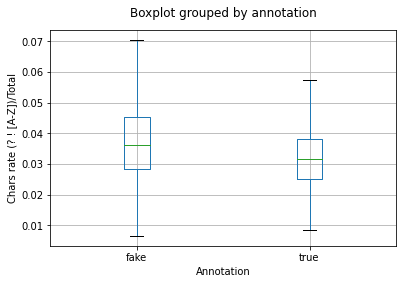

In [7]:
import matplotlib
ax = df.boxplot(column='rate_chars', by='annotation', showfliers=False)
ax.set_ylabel("Chars rate (? ! [A-Z])/Total")
ax.set_xlabel("Annotation")
ax.set_title("");

# Using NLTK - Cleaning

In [8]:
from nltk import download as nltk_download
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

nltk_download("stopwords", quiet=True)
nltk_download("rslp", quiet=True)

stop_words = stopwords.words("portuguese")
stemmer = RSLPStemmer()  # stemmer.stem("texto")

In [9]:
from nltk.tokenize import TweetTokenizer
import string
import unidecode

tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
min_length = 3

def valid(word):
    return len(word) >= min_length and re.match(r"^[a-z]*$", word) and word not in stop_words and word not in string.punctuation

def clean(text):
    #text = re.sub(r"#", "", text) # Remover #
    text = unidecode.unidecode(text)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    
    words = tokenizer.tokenize(text)
 
    return " ".join([word for word in words if valid(word)])

In [10]:
df["text_clean"] = df.text.apply(clean)

In [11]:
df.head()

,file_num,text,annotation,rate_chars,text_clean
0,1,Kátia Abreu diz que vai colocar sua expulsão e...,fake,0.042033,katia abreu diz vai colocar expulsao moldura n...
1,10,"Dr. Ray peita Bolsonaro, chama-o de conservad...",fake,0.021390,ray peita bolsonaro conservador fake entrevist...
2,100,Reinaldo Azevedo desmascarado pela Polícia Fed...,fake,0.036474,reinaldo azevedo desmascarado policia federal ...
3,1000,Relatório assustador do BNDES mostra dinheiro ...,fake,0.026008,relatorio assustador bndes mostra dinheiro pub...
4,1001,"Radialista americano fala sobre o PT: ""Eles ve...",fake,0.021021,radialista americano fala sobre vendem ilusao ...


In [12]:
df["text_stemmed"] = df.text_clean.apply(lambda words: " ".join([ stemmer.stem(word) for word in words.split(" ") ]))
df.head()

,file_num,text,annotation,rate_chars,text_clean,text_stemmed
0,1,Kátia Abreu diz que vai colocar sua expulsão e...,fake,0.042033,katia abreu diz vai colocar expulsao moldura n...,kat abr diz vai coloc expulsa mold nao reclam ...
1,10,"Dr. Ray peita Bolsonaro, chama-o de conservad...",fake,0.021390,ray peita bolsonaro conservador fake entrevist...,ray peit bolsonar conserv fak entrev danil gen...
2,100,Reinaldo Azevedo desmascarado pela Polícia Fed...,fake,0.036474,reinaldo azevedo desmascarado policia federal ...,reinald azeved desmascar polic feder ferrenh c...
3,1000,Relatório assustador do BNDES mostra dinheiro ...,fake,0.026008,relatorio assustador bndes mostra dinheiro pub...,relatori assust bnd mostr dinh publ brasil jor...
4,1001,"Radialista americano fala sobre o PT: ""Eles ve...",fake,0.021021,radialista americano fala sobre vendem ilusao ...,radial americ fal sobr vend ilusa pov brasil p...


# Using NLTK - N-grams

In [13]:
data = pd.DataFrame()
data["text"] = df["text_stemmed"].copy()
data["annotation"] = df["annotation"].copy()
data.head()

,text,annotation
0,kat abr diz vai coloc expulsa mold nao reclam ...,fake
1,ray peit bolsonar conserv fak entrev danil gen...,fake
2,reinald azeved desmascar polic feder ferrenh c...,fake
3,relatori assust bnd mostr dinh publ brasil jor...,fake
4,radial americ fal sobr vend ilusa pov brasil p...,fake


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pickle import dump

vectorizer = TfidfVectorizer(lowercase=False, max_features=1000)

tfidf = vectorizer.fit(data.text)
dump(tfidf, open('web/tfidf.pkl', 'wb')) # output vectorizer for inference in the app

X = tfidf.transform(data.text)
y = 1 * (data.annotation == "fake")

print(tfidf.get_feature_names())

['abaix', 'abert', 'abr', 'abril', 'abus', 'aca', 'acab', 'aceit', 'acess', 'ach', 'acid', 'acim', 'aco', 'acompanh', 'acontec', 'acord', 'acredit', 'acrescent', 'acus', 'acusaca', 'acusaco', 'administr', 'administraca', 'admit', 'adot', 'advog', 'aeci', 'aere', 'aeroport', 'afast', 'afet', 'afirm', 'agenc', 'agend', 'agent', 'agor', 'agost', 'agu', 'aind', 'ajud', 'alcanc', 'alckmin', 'aleg', 'alegr', 'alem', 'alert', 'alg', 'algu', 'algum', 'ali', 'aliment', 'alt', 'alv', 'ameac', 'americ', 'amig', 'analis', 'and', 'ano', 'ant', 'anteri', 'antig', 'antoni', 'anunci', 'aparec', 'apart', 'apen', 'apes', 'aplic', 'apo', 'apoi', 'apont', 'apresent', 'aprov', 'aprovaca', 'apur', 'aqu', 'are', 'argument', 'arm', 'art', 'artig', 'artist', 'assess', 'assim', 'assin', 'assist', 'assum', 'assunt', 'at', 'atac', 'ataqu', 'ate', 'atenca', 'atend', 'ating', 'ativ', 'ato', 'atr', 'atrav', 'atu', 'atuaca', 'atual', 'audienc', 'aument', 'autor', 'autoridad', 'avali', 'avanc', 'bairr', 'baix', 'banc'

In [15]:
print(data.shape)
print(X.shape)

(7200, 2)
(7200, 1000)


# Machine Learning

## Naïve Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [17]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [18]:
ypred = cross_val_predict(clf, X.toarray(), y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=17), n_jobs=-1)

In [19]:
print(precision_score(y, ypred), recall_score(y, ypred), f1_score(y, ypred))

0.8612836438923396 0.8088888888888889 0.8342644320297952


In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

proba = cross_val_predict(clf, X.toarray(), y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=17), n_jobs=-1, method='predict_proba')[:, 1]
fpr, tpr, thr = roc_curve(y, proba)
print("AUC: {}".format(roc_auc_score(y, proba)))

AUC: 0.8913956790123457


### Naïve Bayes - Visualization

[]

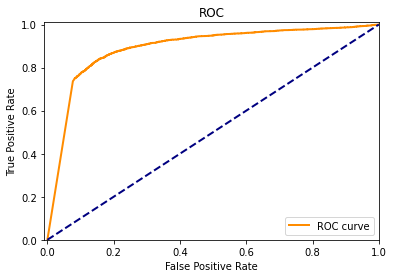

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.plot()

### Extract final model

In [22]:
clf = GaussianNB()
clf.fit(X.toarray(), y)
dump(clf, open('web/clf.pkl', 'wb'))

## KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(metric="cosine")

In [24]:
ypred = cross_val_predict(clf, X.toarray(), y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=17), n_jobs=-1)
print(precision_score(y, ypred), recall_score(y, ypred), f1_score(y, ypred))

0.9342977697408077 0.4305555555555556 0.5894656778855296


In [25]:
clf = KNeighborsClassifier()
ypred = cross_val_predict(clf, X.toarray(), y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=17), n_jobs=-1)
print(precision_score(y, ypred), recall_score(y, ypred), f1_score(y, ypred))

0.9342977697408077 0.4305555555555556 0.5894656778855296


## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)

In [27]:
model = clf.fit(X, y)

### Decision Tree - Visualization

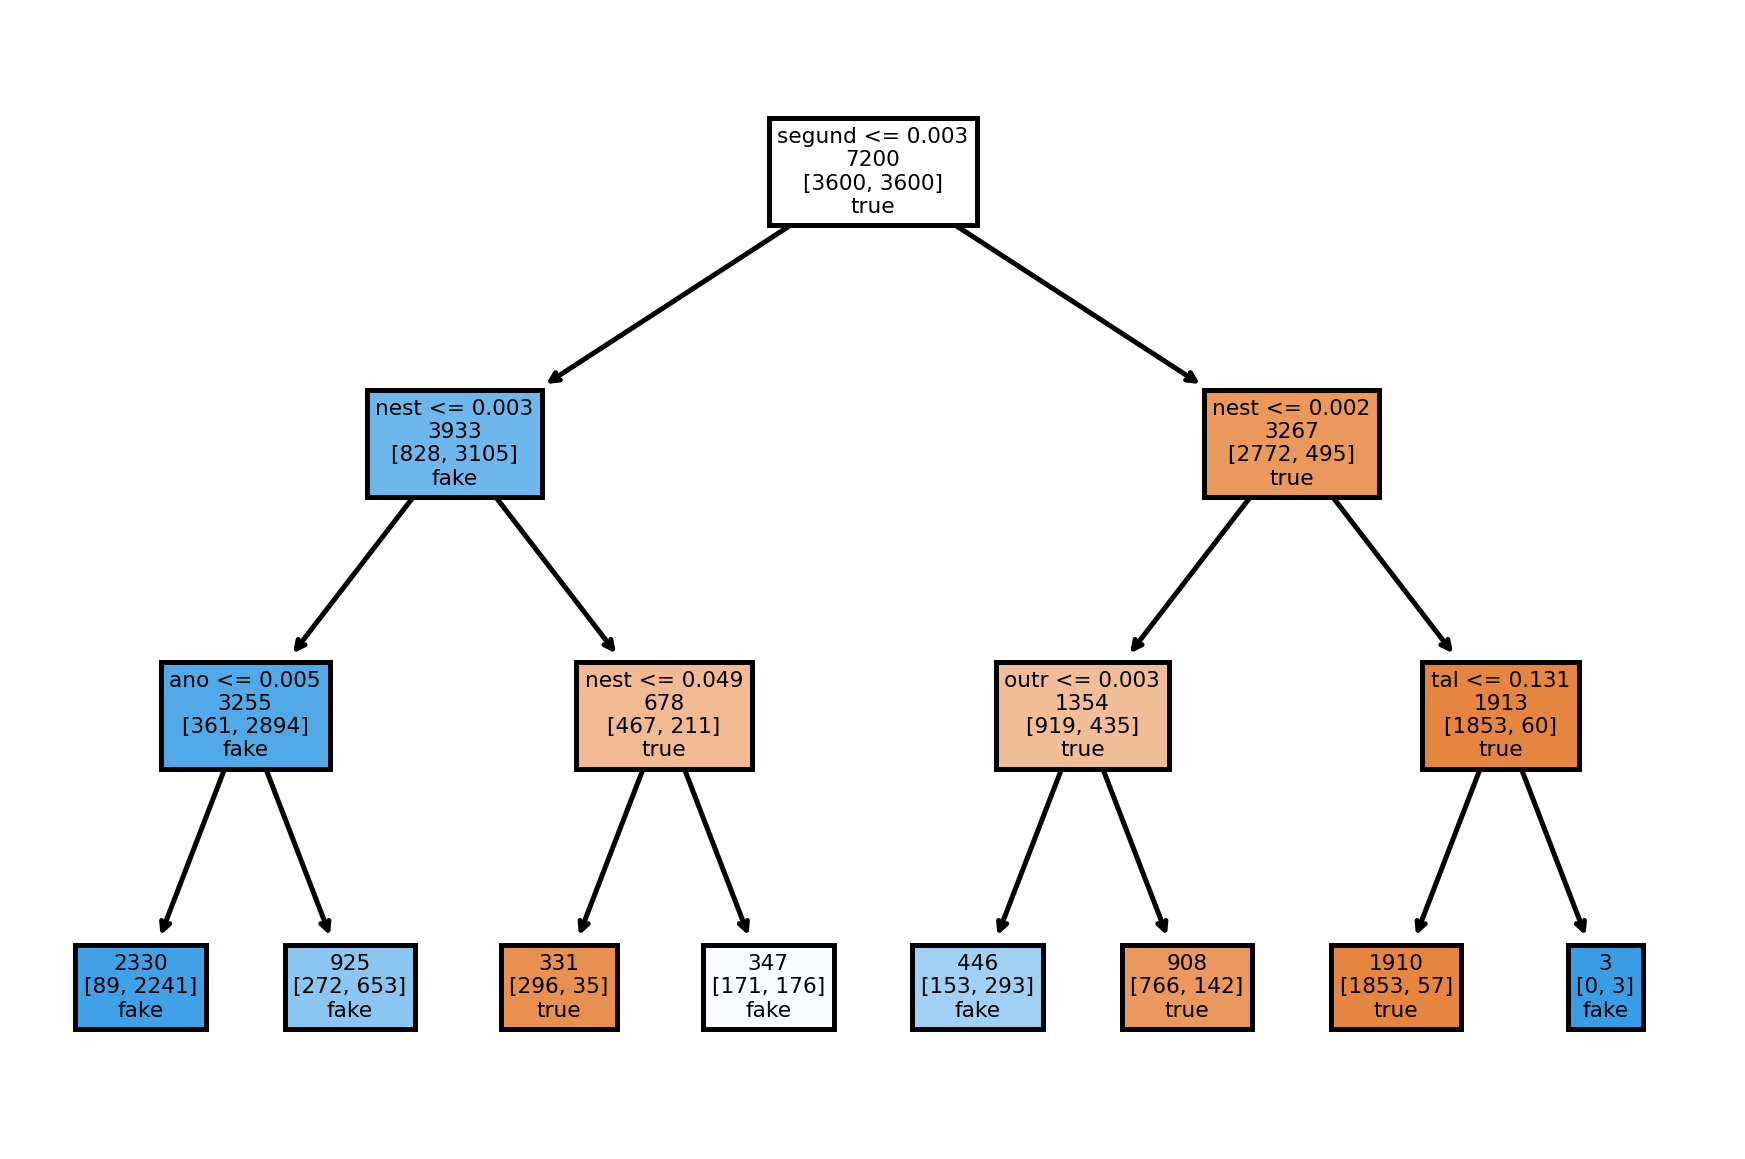

In [28]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(dpi=360)
tree = plot_tree(model, feature_names=tfidf.get_feature_names(), label="none", class_names=["true", "fake"], filled=True, impurity=False)
plt.show()

In [29]:
from sklearn.tree import export_graphviz
export_graphviz(model, out_file='tree.dot', 
                feature_names = tfidf.get_feature_names(),
                class_names = ["true", "fake"],
                rounded=True, proportion=False, 
                precision=2, filled=True, impurity=False)

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')